
NET PRESENT VALUE OF UTILITY (200-YEAR SIMULATION)
Clean Policy NPV Utility: 510.28
Baseline Policy NPV Utility: 500.14
Dirty Policy NPV Utility: 493.69



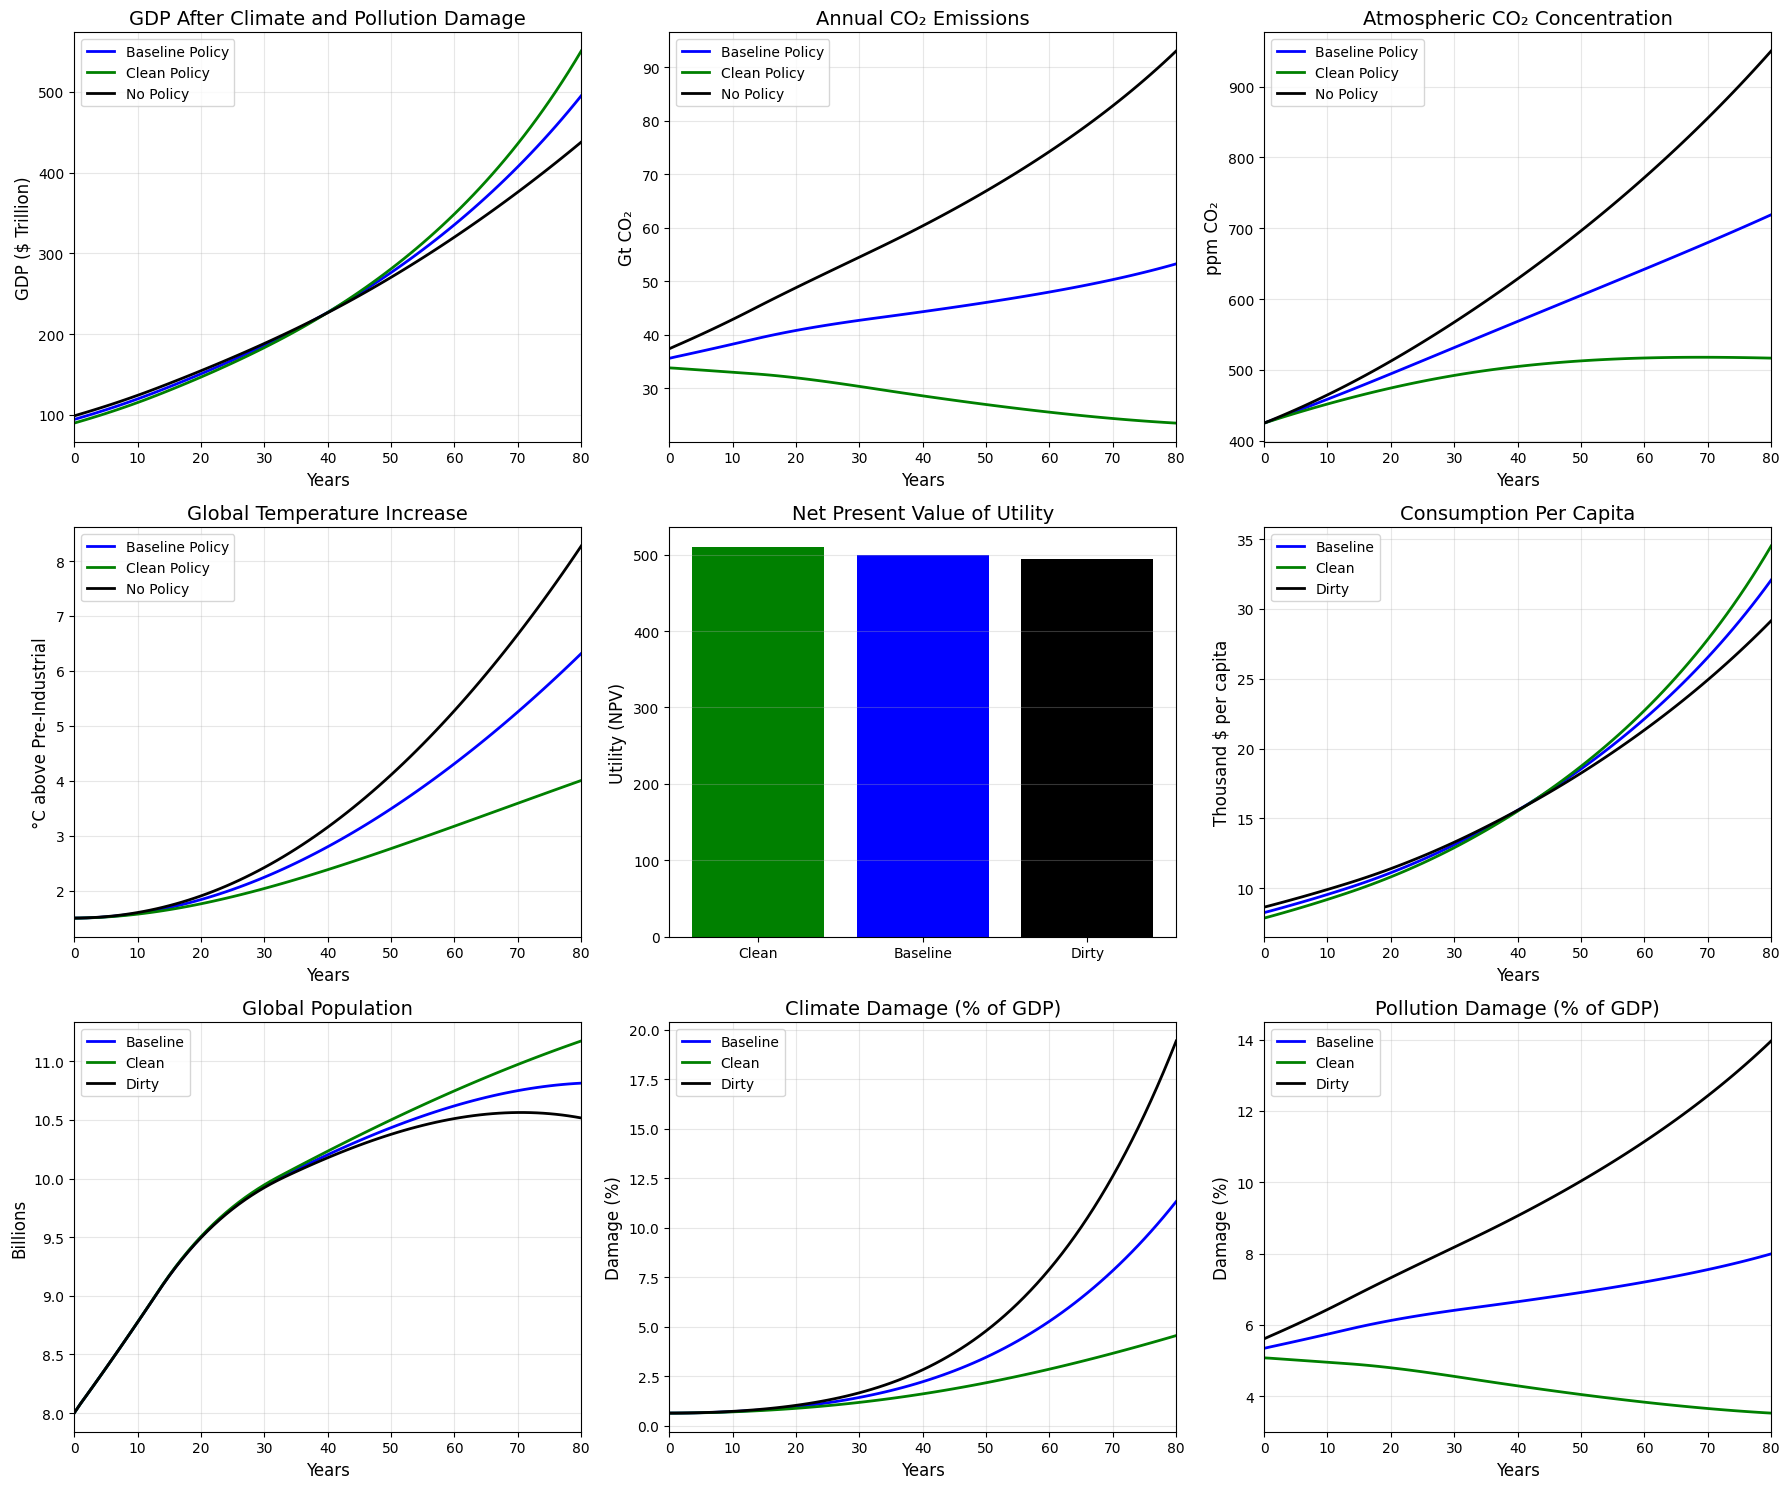


COMPLETE YEAR-BY-YEAR RESULTS

BASELINE POLICY RESULTS
    Year  Population (B)  Pop Growth Rate (%)  GDP ($T)  GDP After Damage ($T)  Emissions (Gt CO₂)  CO₂ (ppm)  Temp Increase (°C)  Climate Damage (%)  Pollution Damage (%)  Consumption PC ($K)
0      0            8.00                 0.00    100.00                  94.36               35.60     425.00                1.50                0.64                  5.34                 8.26
1      1            8.08                 1.00    102.50                  96.68               35.87     428.27                1.50                0.64                  5.38                 8.38
2      2            8.15                 0.93    105.02                  99.02               36.13     431.57                1.50                0.64                  5.42                 8.50
3      3            8.23                 0.92    107.60                 101.41               36.39     434.88                1.51                0.65                  5.46 

In [ ]:
# INTEGRATED CLIMATE-ECONOMIC MODEL
# ======================================================================
# This model simulates the interaction between economic growth, climate change,
# and environmental policies over an 80-year period. It features:
# - Solow economic growth model with capital accumulation
# - Endogenous population dynamics affected by development and pollution
# - Carbon cycle and temperature physics
# - Climate and pollution damage functions
# - Three policy scenarios (baseline, clean, dirty)

# === GREEK LETTER CATALOGUE (PARAMETER DEFINITIONS) ===
# σ = sigma       # Emissions intensity (Gt CO₂ per $ trillion GDP)
# δm = delta_m    # Natural sequestration rate of atmospheric CO₂
# δk = delta_k    # Capital depreciation rate
# ξ = xi          # Fraction of emissions that enter the atmosphere
# φ = phi         # Coefficient for pollution damage function on GDP
# φ_exp = phi_exp # Exponent for pollution damage sensitivity
# λ = lambda_     # Climate sensitivity parameter (response of temperature to forcing)
# γ = gamma       # Heat absorption (damping) parameter
# ψ1 = psi1       # Linear temperature damage coefficient (not used in current setup)
# ψ2 = psi2       # Quadratic temperature damage coefficient
# χ = chi         # Radiative forcing coefficient (Myhre et al. 1998)
# ρ = rho         # Pure rate of social time preference (discounting factor for utility)
# α = alpha       # Capital share of output in production function
# κ = kappa       # TFP growth multiplier for clean scenario
# τ = tau         # TFP growth multiplier for dirty scenario
# ω = omega       # Population weight in utility function
# η = eta         # Elasticity of marginal utility
# θ = theta       # Abatement cost intensity parameter (fraction of GDP lost due to abatement)

# === TABLE OF CONTENTS ===
# 1. IMPORT PACKAGES
# 2. SIMULATION SETTINGS
# 3. ECONOMIC GROWTH PARAMETERS
# 4. ABATEMENT POLICY SCENARIOS
# 5. EMISSIONS PARAMETERS
# 6. ATMOSPHERIC CARBON PARAMETERS
# 7. TEMPERATURE PARAMETERS
# 8. POPULATION GROWTH PARAMETERS
# 9. DAMAGE FUNCTIONS & UTILITY PARAMETERS
# 10. INITIALIZE VECTORS
# 11. INITIAL CONDITIONS
# 12. SIMULATION LOOP
# 13. DAMAGE & UTILITY CALCULATIONS
# 14. DISCOUNTING & NPV CALCULATIONS
# 15. PLOTTING
# 16. RESULTS OUTPUT

# === 1. IMPORT PACKAGES ===
import numpy as np  # Numerical operations
import pandas as pd  # Data handling
import matplotlib.pyplot as plt  # Visualization

# === 2. SIMULATION SETTINGS ===
T = 250  # Simulation duration (years)
years = list(range(T + 1))  # Time vector
display_years = 80  # Years to show in graphs/tables

# === 3. ECONOMIC GROWTH PARAMETERS (SOLOW MODEL) ===
# 3.1 Initial Economic Conditions
Y0 = 100           # Initial GDP ($ trillion)
L0 = 1.0           # Normalized model population
L_pop0 = 8         # Actual population (billions)
y0 = Y0/L_pop0     # Initial GDP per capita

# 3.2 Total Factor Productivity (TFP)
A0 = 1.0           # Initial TFP (baseline)
κ = 0.95           # Clean scenario TFP multiplier (-5%)
τ = 1.05           # Dirty scenario TFP multiplier (+5%)

# 3.3 Production Parameters
α = 0.40           # Capital share (Cobb-Douglas)
K0 = (Y0 / (A0 * L0**(1-α))) ** (1/α)  # Initial capital stock
θ = 0.35           # Abatement cost intensity

# 3.4 Growth Parameters
δk = 0.027         # Capital depreciation rate (2.7%/yr)
s = 0.30           # Savings rate (30% of GDP)
g_A = 0.03        # Baseline TFP growth (3%/yr)
g_A_clean = g_A * 1.02  # Clean scenario TFP growth (2% faster)
g_A_dirty = g_A * 0.98  # Dirty scenario TFP growth (2% slower)

# === 4. ABATEMENT POLICY SCENARIOS ===
# 4.1 Policy Definitions
muVec_clean = np.linspace(0.0, 0.5, T + 1)    # Clean: 0→50% abatement
muVec_dirty = np.zeros(T + 1)                 # Dirty: 0% abatement
muVec_baseline = np.linspace(0.0, 0.25, T + 1) # Baseline: 0→25% abatement

# === 5. EMISSIONS PARAMETERS ===
# 5.1 Emissions Intensity
σ0 = 0.356          # Initial emissions intensity (GtCO₂/$trillion GDP)
decay_rate = 0.016  # Annual intensity decline (baseline: 1.6%)
decay_rate_clean = 0.025  # Clean scenario decline (2.5%/yr)
decay_rate_dirty = 0.01  # Dirty scenario decline (1%/yr)

# 5.2 Emissions Intensity Functions
def σ(t):
    """Baseline emissions intensity decay function"""
    return σ0 * (1 - decay_rate) ** t

def σ_dirty(t):
    """Dirty scenario emissions intensity decay function"""
    return σ0 * (1 - decay_rate_dirty) ** t

def σ_clean(t):
    """Clean scenario emissions intensity decay function"""
    return σ0 * (1 - decay_rate_clean) ** t

# === 6. ATMOSPHERIC CARBON PARAMETERS ===
C0 = 425            # Initial CO₂ concentration (ppm)
δm = 0.01           # Natural sequestration rate (1%/yr)
ξ = 0.45            # Atmospheric fraction (45%)
GT_TO_PPM = 1 / 2.13  # Conversion: GtCO₂ to ppm (2.13 GtCO₂ = 1 ppm)

# === 7. TEMPERATURE PARAMETERS ===
T0 = 1.5            # Initial temperature anomaly (°C)
χ = 5.35            # Radiative forcing coefficient (W/m²)
λ = 0.04            # Climate sensitivity (°C per W/m²)
γ = 0.004           # Heat absorption coefficient

# === 8. POPULATION GROWTH PARAMETERS ===
# 8.1 Growth Rate Bounds
n_max = 0.012       # Maximum growth rate (1.2%/yr)
n_min = -0.01       # Minimum growth rate (-1%/yr)

# 8.2 Development Threshold
y_threshold = 15.0 # GDP/capita for demographic transition ($15k)

# 8.3 Impact Coefficients
γ_pop = 0.4                 # Development sensitivity
pollution_elasticity = 0.45  # Pollution impact on growth
climate_elasticity = 0.15   # Climate impact on growth

# 8.4 Population Limit Parameters
pop_limit = 10.0            # Population limit (billion)
pop_limit_penalty = 0.65    # Growth reduction when above limit (65%)
pop_limit_start = 9.0       # Soft limit start (billion)

# 8.5 Population Growth Function
def population_growth(y_pc, E, T, t, current_pop):
    """
    Endogenous population growth with consistent units
        y_pc: GDP per capita (thousand dollars)
        E: Emissions (GtCO₂)
        T: Temperature anomaly (°C)
        t: Time period
        current_pop: Current population (billions)
    """
    # Logistic development factor
    development_factor = 1 / (1 + np.exp(γ_pop * (-y_pc - y_threshold)))

    # Base growth rate
    n_base = n_min + (n_max - n_min) * development_factor

    # Pollution impact (relative to initial emissions)
    pollution_impact = 1 - pollution_elasticity * (E/E0)

    # Climate impact
    climate_impact = 1 - climate_elasticity * T

    # Effective growth rate
    effective_growth = n_base * pollution_impact * climate_impact

    # Exogenous population limit effect
    if current_pop > pop_limit_start:
        exceed_factor = min(1.0, (current_pop - pop_limit_start) / (pop_limit - pop_limit_start))
        effective_growth *= (1 - pop_limit_penalty * exceed_factor)

    return np.clip(effective_growth, n_min, n_max)

# === 9. DAMAGE FUNCTIONS & UTILITY PARAMETERS ===
# 9.1 Climate Damage Parameters
ψ1 = 0.0          # Linear damage coefficient (disabled)
ψ2 = 0.00284      # Quadratic damage coefficient (DICE value)

# 9.2 Pollution Damage Parameters
φ = 0.0015        # Pollution damage coefficient
φ_exp = 1.0       # Damage exponent (linear)

# 9.3 Utility Parameters
ρ = 0.03          # Discount rate (3%/yr)
ω = 1.0           # Population weight
η = 1.45          # Elasticity of marginal utility

# === 10. INITIALIZE VECTORS ===
# 10.1 Economic Vectors
AVec = np.zeros(T + 1)    # Total Factor Productivity
KVec = np.zeros(T + 1)    # Capital stock
YVec = np.zeros(T + 1)    # GDP output
IVec = np.zeros(T + 1)    # Investment

# 10.2 Scenario Vectors (Clean)
AVec_clean = np.zeros(T + 1)
KVec_clean = np.zeros(T + 1)
YVec_clean = np.zeros(T + 1)
IVec_clean = np.zeros(T + 1)

# 10.3 Scenario Vectors (Dirty)
AVec_dirty = np.zeros(T + 1)
KVec_dirty = np.zeros(T + 1)
YVec_dirty = np.zeros(T + 1)
IVec_dirty = np.zeros(T + 1)

# 10.4 Population Vectors
LVec = np.zeros(T + 1)        # Normalized labor
LVec_clean = np.zeros(T + 1)
LVec_dirty = np.zeros(T + 1)
LPopVec = np.zeros(T + 1)     # Actual population (billions)
LPopVec_clean = np.zeros(T + 1)
LPopVec_dirty = np.zeros(T + 1)
growth_rate_vec = np.zeros(T + 1)  # Population growth rates

# 10.5 Emissions Vectors
EVec_clean = np.zeros(T + 1)
EVec_dirty = np.zeros(T + 1)
EVec_baseline = np.zeros(T + 1)

# 10.6 Climate Vectors
CVec = np.zeros(T + 1)        # Atmospheric CO₂ (ppm)
CVec_clean = np.zeros(T + 1)
CVec_dirty = np.zeros(T + 1)
FVec = np.zeros(T + 1)        # Radiative forcing (W/m²)
FVec_clean = np.zeros(T + 1)
FVec_dirty = np.zeros(T + 1)
TVec = np.zeros(T + 1)        # Temperature anomaly (°C)
TVec_clean = np.zeros(T + 1)
TVec_dirty = np.zeros(T + 1)

# 10.7 Damage & Utility Vectors
D_climate_frac = np.zeros(T+1)        # Climate damage fraction
D_pollution_frac = np.zeros(T+1)      # Pollution damage fraction
Y_after_damage = np.zeros(T+1)        # GDP after damages
Consumption = np.zeros(T+1)           # Consumption
Utility = np.zeros(T+1)               # Period utility

# Scenario-specific vectors
D_climate_frac_clean = np.zeros(T+1)
D_pollution_frac_clean = np.zeros(T+1)
Y_after_damage_clean = np.zeros(T+1)
Consumption_clean = np.zeros(T+1)
Utility_clean = np.zeros(T+1)

D_climate_frac_dirty = np.zeros(T+1)
D_pollution_frac_dirty = np.zeros(T+1)
Y_after_damage_dirty = np.zeros(T+1)
Consumption_dirty = np.zeros(T+1)
Utility_dirty = np.zeros(T+1)

# === 11. INITIAL CONDITIONS ===
# 11.1 Economic Initialization
LVec[0] = L0
LPopVec[0] = L_pop0
growth_rate_vec[0] = n_max
AVec[0] = A0
KVec[0] = K0
YVec[0] = Y0

# 11.2 Scenario Initialization
AVec_clean[0] = A0 * κ
KVec_clean[0] = K0
LVec_clean[0] = L0
LPopVec_clean[0] = L_pop0

AVec_dirty[0] = A0 * τ
KVec_dirty[0] = K0
LVec_dirty[0] = L0
LPopVec_dirty[0] = L_pop0

# 11.3 Climate Initialization
CVec[0] = C0
CVec_clean[0] = C0
CVec_dirty[0] = C0
TVec[0] = T0
TVec_clean[0] = T0
TVec_dirty[0] = T0

# 11.4 Initial GDP and Emissions
YVec[0] = Y0
YVec_clean[0] = (A0 * κ) * (K0**α) * (L0**(1-α))
YVec_dirty[0] = (A0 * τ) * (K0**α) * (L0**(1-α))

EVec_baseline[0] = (1 - muVec_baseline[0]) * σ(0) * YVec[0]
EVec_clean[0] = (1 - muVec_clean[0]) * σ_clean(0) * YVec_clean[0]
EVec_dirty[0] = (1 - muVec_dirty[0]) * σ_dirty(0) * YVec_dirty[0]

E0 = EVec_baseline[0]  # Critical for population function

# === 12. SIMULATION LOOP ===
for t in range(T):
    # 12.1 Population Growth
    # Baseline scenario
    y_pc_current = (YVec[t]/LPopVec[t])
    n_current = population_growth(y_pc_current, EVec_baseline[t], TVec[t], t, LPopVec[t])

    if t == 0:
        n_current = 0.01

    LVec[t+1] = LVec[t] * (1 + n_current)
    LPopVec[t+1] = LPopVec[t] * (1 + n_current)

    # Clean scenario
    y_pc_current_clean = (YVec_clean[t]/LPopVec_clean[t])
    n_current_clean = population_growth(y_pc_current_clean, EVec_clean[t], TVec_clean[t], t, LPopVec_clean[t])

    if t == 0:
        n_current_clean = 0.01

    LVec_clean[t+1] = LVec_clean[t] * (1 + n_current_clean)
    LPopVec_clean[t+1] = LPopVec_clean[t] * (1 + n_current_clean)

    # Dirty scenario
    y_pc_current_dirty = (YVec_dirty[t]/LPopVec_dirty[t])
    n_current_dirty = population_growth(y_pc_current_dirty, EVec_dirty[t], TVec_dirty[t], t, LPopVec_dirty[t])

    if t == 0:
        n_current_dirty = 0.01

    LVec_dirty[t+1] = LVec_dirty[t] * (1 + n_current_dirty)

    LPopVec_dirty[t+1] = LPopVec_dirty[t] * (1 + n_current_dirty)

    # 12.2 Economic Growth (Solow Model)
    # TFP growth
    AVec[t+1] = AVec[t] * (1 + g_A)
    AVec_clean[t+1] = AVec_clean[t] * (1 + g_A_clean)
    AVec_dirty[t+1] = AVec_dirty[t] * (1 + g_A_dirty)

    # Production before abatement
    Y_raw = AVec[t] * (KVec[t] ** α) * (LVec[t] ** (1 - α))
    Y_raw_clean = AVec_clean[t] * (KVec_clean[t] ** α) * (LVec_clean[t] ** (1 - α))
    Y_raw_dirty = AVec_dirty[t] * (KVec_dirty[t] ** α) * (LVec_dirty[t] ** (1 - α))

    # Abatement costs
    abatement_cost_frac = θ * (muVec_baseline[t] ** 2)
    abatement_cost_frac_clean = θ * (muVec_clean[t] ** 2)
    abatement_cost_frac_dirty = θ * (muVec_dirty[t] ** 2)

    # Adjusted GDP
    YVec[t] = Y_raw * (1 - abatement_cost_frac)
    YVec_clean[t] = Y_raw_clean * (1 - abatement_cost_frac_clean)
    YVec_dirty[t] = Y_raw_dirty * (1 - abatement_cost_frac_dirty)

    # Capital accumulation
    IVec[t] = s * YVec[t]
    KVec[t+1] = (1 - δk) * KVec[t] + IVec[t]

    IVec_clean[t] = s * YVec_clean[t]
    KVec_clean[t+1] = (1 - δk) * KVec_clean[t] + IVec_clean[t]

    IVec_dirty[t] = s * YVec_dirty[t]
    KVec_dirty[t+1] = (1 - δk) * KVec_dirty[t] + IVec_dirty[t]

    # 12.3 Emissions Calculation
    EVec_baseline[t] = (1 - muVec_baseline[t]) * σ(t) * YVec[t]
    EVec_clean[t] = (1 - muVec_clean[t]) * σ_clean(t) * YVec_clean[t]
    EVec_dirty[t] = (1 - muVec_dirty[t]) * σ_dirty(t) * YVec_dirty[t]

    # 12.4 Atmospheric Carbon Update
    # Convert emissions to ppm
    EVec_baseline_ppm = EVec_baseline * GT_TO_PPM
    EVec_clean_ppm = EVec_clean * GT_TO_PPM
    EVec_dirty_ppm = EVec_dirty * GT_TO_PPM

    # Carbon accumulation
    CVec[t+1] = (1 - δm) * CVec[t] + ξ * EVec_baseline_ppm[t]
    CVec_clean[t+1] = (1 - δm) * CVec_clean[t] + ξ * EVec_clean_ppm[t]
    CVec_dirty[t+1] = (1 - δm) * CVec_dirty[t] + ξ * EVec_dirty_ppm[t]

    # 12.5 Temperature Calculation
    # Radiative forcing
    FVec[t+1] = χ * np.log(max(CVec[t+1], 1e-10) / C0)
    FVec_clean[t+1] = χ * np.log(max(CVec_clean[t+1], 1e-10) / C0)
    FVec_dirty[t+1] = χ * np.log(max(CVec_dirty[t+1], 1e-10) / C0)

    # Temperature dynamics
    TVec[t+1] = TVec[t] + λ * (FVec[t+1] - γ * TVec[t])
    TVec_clean[t+1] = TVec_clean[t] + λ * (FVec_clean[t+1] - γ * TVec_clean[t])
    TVec_dirty[t+1] = TVec_dirty[t] + λ * (FVec_dirty[t+1] - γ * TVec_dirty[t])

# 12.6 Final Year Calculations
# Baseline
Y_raw_final = AVec[T] * (KVec[T] ** α) * (LVec[T] ** (1 - α))
YVec[T] = Y_raw_final * (1 - θ * (muVec_baseline[T] ** 2))

# Clean
Y_raw_clean_final = AVec_clean[T] * (KVec_clean[T] ** α) * (LVec_clean[T] ** (1 - α))
YVec_clean[T] = Y_raw_clean_final * (1 - θ * (muVec_clean[T] ** 2))

# Dirty
Y_raw_dirty_final = AVec_dirty[T] * (KVec_dirty[T] ** α) * (LVec_dirty[T] ** (1 - α))
YVec_dirty[T] = Y_raw_dirty_final * (1 - θ * (muVec_dirty[T] ** 2))

# 12.7 Final Year Emissions Calculation
EVec_baseline[T] = (1 - muVec_baseline[T]) * σ(T) * YVec[T]
EVec_clean[T] = (1 - muVec_clean[T]) * σ_clean(T) * YVec_clean[T]
EVec_dirty[T] = (1 - muVec_dirty[T]) * σ_dirty(T) * YVec_dirty[T]

# === 13. DAMAGE & UTILITY CALCULATIONS ===
for t in range(T+1):
    # 13.1 Baseline Scenario
    # Climate damage (quadratic in temperature)
    D_climate_frac[t] = ψ1 * TVec[t] + ψ2 * TVec[t]**2
    # Pollution damage (linear in emissions)
    D_pollution_frac[t] = φ * EVec_baseline[t]**φ_exp
    # Effective GDP
    Y_after_damage[t] = YVec[t] / (1 + D_climate_frac[t] + D_pollution_frac[t])
    # Consumption
    Consumption[t] = Y_after_damage[t] * (1 - s)
    # Utility (CRRA)
    C_pc = Consumption[t] / LPopVec[t]
    if η == 1:
        Utility[t] = LPopVec[t] * np.log(C_pc)
    else:
        Utility[t] = LPopVec[t] * (C_pc**(1-η) - 1)/(1-η)

    # 13.2 Clean Scenario
    D_climate_frac_clean[t] = ψ1 * TVec_clean[t] + ψ2 * TVec_clean[t]**2
    D_pollution_frac_clean[t] = φ * EVec_clean[t]**φ_exp
    Y_after_damage_clean[t] = YVec_clean[t] / (1 + D_climate_frac_clean[t] + D_pollution_frac_clean[t])
    Consumption_clean[t] = Y_after_damage_clean[t] * (1 - s)
    C_pc_clean = Consumption_clean[t] / LPopVec_clean[t]
    if η == 1:
        Utility_clean[t] = LPopVec_clean[t] * np.log(C_pc_clean)
    else:
        Utility_clean[t] = LPopVec_clean[t] * (C_pc_clean**(1-η) - 1)/(1-η)

    # 13.3 Dirty Scenario
    D_climate_frac_dirty[t] = ψ1 * TVec_dirty[t] + ψ2 * TVec_dirty[t]**2
    D_pollution_frac_dirty[t] = φ * EVec_dirty[t]**φ_exp
    Y_after_damage_dirty[t] = YVec_dirty[t] / (1 + D_climate_frac_dirty[t] + D_pollution_frac_dirty[t])
    Consumption_dirty[t] = Y_after_damage_dirty[t] * (1 - s)
    C_pc_dirty = Consumption_dirty[t] / LPopVec_dirty[t]
    if η == 1:
        Utility_dirty[t] = LPopVec_dirty[t] * np.log(C_pc_dirty)
    else:
        Utility_dirty[t] = LPopVec_dirty[t] * (C_pc_dirty**(1-η) - 1)/(1-η)

# === 14. DISCOUNTING & NPV CALCULATIONS ===
# 14.1 Consumption Growth Rates
g = np.zeros(T+1)
for t in range(1, T+1):
    g[t] = (Consumption[t]/Consumption[t-1]) - 1 if t > 0 and Consumption[t-1] > 0 else 0

# 14.2 Discount Factors (Ramsey discounting)
Discount_Factors = np.ones(T+1)
for t in range(1, T+1):
    Discount_Factors[t] = Discount_Factors[t-1] / (1 + ρ)

# 14.3 Net Present Value of Utility
NPV_Utility = np.sum(Utility * Discount_Factors)
NPV_Utility_clean = np.sum(Utility_clean * Discount_Factors)
NPV_Utility_dirty = np.sum(Utility_dirty * Discount_Factors)

print("\n" + "="*50)
print("NET PRESENT VALUE OF UTILITY (200-YEAR SIMULATION)")
print("="*50)
print(f"Clean Policy NPV Utility: {NPV_Utility_clean:,.2f}")
print(f"Baseline Policy NPV Utility: {NPV_Utility:,.2f}")
print(f"Dirty Policy NPV Utility: {NPV_Utility_dirty:,.2f}")
print("="*50 + "\n")

# === 15. PLOTTING ===
plt.figure(figsize=(18, 15))

# Define consistent colors
color_baseline = 'blue'  # Blue
color_clean = 'green'     # Green
color_dirty = 'black'     # Red

# Plot 1: GDP Comparison
plt.subplot(3, 3, 1)
plt.plot(years[:display_years+1], Y_after_damage[:display_years+1], label="Baseline Policy", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], Y_after_damage_clean[:display_years+1], label="Clean Policy", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], Y_after_damage_dirty[:display_years+1], label="No Policy", color=color_dirty, linewidth=2)
plt.title("GDP After Climate and Pollution Damage", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("GDP ($ Trillion)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 2: Emissions Comparison
plt.subplot(3, 3, 2)
plt.plot(years[:display_years+1], EVec_baseline[:display_years+1], label="Baseline Policy", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], EVec_clean[:display_years+1], label="Clean Policy", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], EVec_dirty[:display_years+1], label="No Policy", color=color_dirty, linewidth=2)
plt.title("Annual CO₂ Emissions", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Gt CO₂", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 3: Atmospheric CO₂
plt.subplot(3, 3, 3)
plt.plot(years[:display_years+1], CVec[:display_years+1], label="Baseline Policy", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], CVec_clean[:display_years+1], label="Clean Policy", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], CVec_dirty[:display_years+1], label="No Policy", color=color_dirty, linewidth=2)
plt.title("Atmospheric CO₂ Concentration", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("ppm CO₂", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 4: Temperature
plt.subplot(3, 3, 4)
plt.plot(years[:display_years+1], TVec[:display_years+1], label="Baseline Policy", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], TVec_clean[:display_years+1], label="Clean Policy", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], TVec_dirty[:display_years+1], label="No Policy", color=color_dirty, linewidth=2)
plt.title("Global Temperature Increase", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("°C above Pre-Industrial", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 5: NPV Utility (no changes needed here)
plt.subplot(3, 3, 5)
plt.bar(["Clean", "Baseline", "Dirty"],
        [NPV_Utility_clean, NPV_Utility, NPV_Utility_dirty],
        color=[color_clean, color_baseline, color_dirty])
plt.title("Net Present Value of Utility", fontsize=14)
plt.ylabel("Utility (NPV)", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Plot 6: Consumption Per Capita
plt.subplot(3, 3, 6)
plt.plot(years[:display_years+1], (Consumption / LPopVec)[:display_years+1], label="Baseline", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], (Consumption_clean / LPopVec_clean)[:display_years+1], label="Clean", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], (Consumption_dirty / LPopVec_dirty)[:display_years+1], label="Dirty", color=color_dirty, linewidth=2)
plt.title("Consumption Per Capita", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Thousand $ per capita", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 7: Population
plt.subplot(3, 3, 7)
plt.plot(years[:display_years+1], LPopVec[:display_years+1], label="Baseline", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], LPopVec_clean[:display_years+1], label="Clean", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], LPopVec_dirty[:display_years+1], label="Dirty", color=color_dirty, linewidth=2)
plt.title("Global Population", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Billions", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 8: Climate Damage
plt.subplot(3, 3, 8)
plt.plot(years[:display_years+1], (D_climate_frac * 100)[:display_years+1], label="Baseline", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], (D_climate_frac_clean * 100)[:display_years+1], label="Clean", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], (D_climate_frac_dirty * 100)[:display_years+1], label="Dirty", color=color_dirty, linewidth=2)
plt.title("Climate Damage (% of GDP)", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Damage (%)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

# Plot 9: Pollution Damage
plt.subplot(3, 3, 9)
plt.plot(years[:display_years+1], (D_pollution_frac * 100)[:display_years+1], label="Baseline", color=color_baseline, linewidth=2)
plt.plot(years[:display_years+1], (D_pollution_frac_clean * 100)[:display_years+1], label="Clean", color=color_clean, linewidth=2)
plt.plot(years[:display_years+1], (D_pollution_frac_dirty * 100)[:display_years+1], label="Dirty", color=color_dirty, linewidth=2)
plt.title("Pollution Damage (% of GDP)", fontsize=14)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Damage (%)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, display_years)

plt.tight_layout()
plt.savefig("climate_economic_model_results.png", dpi=300)
plt.show()

# === 16. RESULTS OUTPUT ===
print("\n" + "="*50)
print("COMPLETE YEAR-BY-YEAR RESULTS")
print("="*50)

# Function to calculate annual growth rate
def calculate_growth_rate(current, previous):
    return (current / previous - 1) * 100 if previous != 0 else 0

# Baseline results
baseline_results = pd.DataFrame({
    'Year': years[:display_years+1],
    'Population (B)': LPopVec[:display_years+1],
    'Pop Growth Rate (%)': [calculate_growth_rate(LPopVec[i], LPopVec[i-1]) if i > 0 else 0 for i in range(display_years+1)],
    'GDP ($T)': YVec[:display_years+1],
    'GDP After Damage ($T)': Y_after_damage[:display_years+1],
    'Emissions (Gt CO₂)': EVec_baseline[:display_years+1],
    'CO₂ (ppm)': CVec[:display_years+1],
    'Temp Increase (°C)': TVec[:display_years+1],
    'Climate Damage (%)': (D_climate_frac * 100)[:display_years+1],
    'Pollution Damage (%)': (D_pollution_frac * 100)[:display_years+1],
    'Consumption PC ($K)': (Consumption / LPopVec)[:display_years+1]})

# Clean policy results
clean_results = pd.DataFrame({
    'Year': years[:display_years+1],
    'Population (B)': LPopVec_clean[:display_years+1],
    'Pop Growth Rate (%)': [calculate_growth_rate(LPopVec_clean[i], LPopVec_clean[i-1]) if i > 0 else 0 for i in range(display_years+1)],
    'GDP ($T)': YVec_clean[:display_years+1],
    'GDP After Damage ($T)': Y_after_damage_clean[:display_years+1],
    'Emissions (Gt CO₂)': EVec_clean[:display_years+1],
    'CO₂ (ppm)': CVec_clean[:display_years+1],
    'Temp Increase (°C)': TVec_clean[:display_years+1],
    'Climate Damage (%)': (D_climate_frac_clean * 100)[:display_years+1],
    'Pollution Damage (%)': (D_pollution_frac_clean * 100)[:display_years+1],
    'Consumption PC ($K)': (Consumption_clean / LPopVec_clean)[:display_years+1]})

# Dirty policy results
dirty_results = pd.DataFrame({
    'Year': years[:display_years+1],
    'Population (B)': LPopVec_dirty[:display_years+1],
    'Pop Growth Rate (%)': [calculate_growth_rate(LPopVec_dirty[i], LPopVec_dirty[i-1]) if i > 0 else 0 for i in range(display_years+1)],
    'GDP ($T)': YVec_dirty[:display_years+1],
    'GDP After Damage ($T)': Y_after_damage_dirty[:display_years+1],
    'Emissions (Gt CO₂)': EVec_dirty[:display_years+1],
    'CO₂ (ppm)': CVec_dirty[:display_years+1],
    'Temp Increase (°C)': TVec_dirty[:display_years+1],
    'Climate Damage (%)': (D_climate_frac_dirty * 100)[:display_years+1],
    'Pollution Damage (%)': (D_pollution_frac_dirty * 100)[:display_years+1],
    'Consumption PC ($K)': (Consumption_dirty / LPopVec_dirty)[:display_years+1]})

# Print baseline results
print("\n" + "="*50)
print("BASELINE POLICY RESULTS")
print("="*50)
print(baseline_results.to_string(float_format="%.2f"))

# Print clean policy results
print("\n" + "="*50)
print("CLEAN POLICY RESULTS")
print("="*50)
print(clean_results.to_string(float_format="%.2f"))

# Print dirty policy results
print("\n" + "="*50)
print("NO POLICY (DIRTY) RESULTS")
print("="*50)
print(dirty_results.to_string(float_format="%.2f"))